In [1]:
# importing necessary libraries 

import numpy as np 
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix,accuracy_score,f1_score,recall_score
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import statsmodels.api as sml

# stops python from showing scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Import Data and drop unnecessary columns 

In [2]:

data = pd.read_csv('../Data/training_set_features.csv', index_col='respondent_id')
target = pd.read_csv('../Data/training_set_labels.csv', index_col='respondent_id')
holdout_set = pd.read_csv('../Data/test_set_features.csv', index_col='respondent_id')

In [3]:
# We only need the 'h1n1_vaccine' column as our target variable so we'll turn it into a panda series with just that column. 
target = pd.Series(target['h1n1_vaccine'])

In [4]:
# inspect the values 
target.value_counts(normalize=True)

0   0.79
1   0.21
Name: h1n1_vaccine, dtype: float64

In [5]:
# drop unnecessary columns in features
drop_feats = ['opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc','hhs_geo_region',
            'employment_industry','employment_occupation','census_msa','health_insurance','behavioral_antiviral_meds']

features = data.drop(columns=drop_feats)


In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_avoidance         26499 non-null  float64
 3   behavioral_face_mask         26688 non-null  float64
 4   behavioral_wash_hands        26665 non-null  float64
 5   behavioral_large_gatherings  26620 non-null  float64
 6   behavioral_outside_home      26625 non-null  float64
 7   behavioral_touch_face        26579 non-null  float64
 8   doctor_recc_h1n1             24547 non-null  float64
 9   doctor_recc_seasonal         24547 non-null  float64
 10  chronic_med_condition        25736 non-null  float64
 11  child_under_6_months         25887 non-null  float64
 12  health_worker                25903 non-null  float64
 13  opinion_h1n1_vac

In [7]:
#convert all object columns to dummies
features = pd.get_dummies(features,columns = ['employment_status','age_group','education','race','income_poverty'])



In [8]:
#convert sex to binary, 0: male, 1:female

features['sex'] = features['sex'].replace({'Female':1,'Male':0})

features['sex'] = pd.to_numeric(features['sex'])

features['sex']

respondent_id
0        1
1        0
2        0
3        1
4        1
        ..
26702    1
26703    0
26704    1
26705    1
26706    0
Name: sex, Length: 26707, dtype: int64

In [9]:
features['marital_status']

respondent_id
0        Not Married
1        Not Married
2        Not Married
3        Not Married
4            Married
            ...     
26702    Not Married
26703    Not Married
26704    Not Married
26705        Married
26706        Married
Name: marital_status, Length: 26707, dtype: object

In [10]:
#convert marital status to binary, 0: single, 1:married

features['marital_status'] = features['marital_status'].replace({'Married':'1','Not Married':'0'})

features['marital_status'] = features['marital_status'].astype(int,errors='ignore')

features['marital_status'].value_counts()


1    13555
0    11744
Name: marital_status, dtype: int64

In [11]:
# convert rent or own to binary: 0 rent, 1 own

features['rent_or_own'] = features['rent_or_own'].replace({'Own':'1','Rent':'0'})
features['rent_or_own'].astype(int,errors='ignore',copy=False)

features['rent_or_own']

respondent_id
0        1
1        0
2        1
3        0
4        1
        ..
26702    1
26703    0
26704    1
26705    0
26706    1
Name: rent_or_own, Length: 26707, dtype: object

In [12]:
features = features.astype('float64')
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 40 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   h1n1_concern                              26615 non-null  float64
 1   h1n1_knowledge                            26591 non-null  float64
 2   behavioral_avoidance                      26499 non-null  float64
 3   behavioral_face_mask                      26688 non-null  float64
 4   behavioral_wash_hands                     26665 non-null  float64
 5   behavioral_large_gatherings               26620 non-null  float64
 6   behavioral_outside_home                   26625 non-null  float64
 7   behavioral_touch_face                     26579 non-null  float64
 8   doctor_recc_h1n1                          24547 non-null  float64
 9   doctor_recc_seasonal                      24547 non-null  float64
 10  chronic_med_condition             

In [13]:
merge_df = features.merge(target,how='left',on='respondent_id')



merge_df.dropna(inplace=True)

merge_df.describe()

#split back into X,y

y = merge_df['h1n1_vaccine']
X = merge_df.drop('h1n1_vaccine',axis=1,inplace=False)

In [14]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21923 entries, 0 to 26706
Data columns (total 41 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   h1n1_concern                              21923 non-null  float64
 1   h1n1_knowledge                            21923 non-null  float64
 2   behavioral_avoidance                      21923 non-null  float64
 3   behavioral_face_mask                      21923 non-null  float64
 4   behavioral_wash_hands                     21923 non-null  float64
 5   behavioral_large_gatherings               21923 non-null  float64
 6   behavioral_outside_home                   21923 non-null  float64
 7   behavioral_touch_face                     21923 non-null  float64
 8   doctor_recc_h1n1                          21923 non-null  float64
 9   doctor_recc_seasonal                      21923 non-null  float64
 10  chronic_med_condition             

In [15]:
#train test split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25)

0.8378542756355675 0.819376026272578


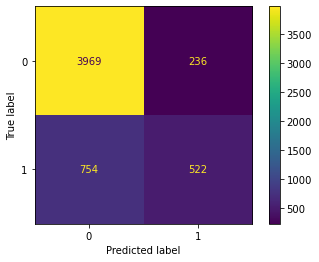

In [16]:
#instantiate decisiontree classifier

tree_clf = DecisionTreeClassifier(criterion='gini',max_depth=7,random_state =42 )

tree_clf.fit(X_train,y_train)

print(tree_clf.score(X_train,y_train),tree_clf.score(X_test,y_test))

plot_confusion_matrix(tree_clf,X_test,y_test)

Train accuracy score: 0.843753801240725
Test accuracy score: 0.8328772121875571
accuracy: 0.8328772121875571


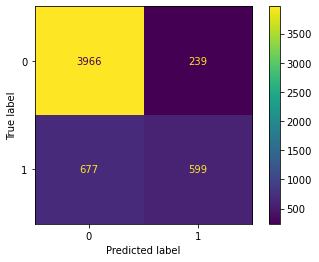

In [17]:
#bagging model overview

#instantiate bagging on tree_clf model

btc = BaggingClassifier(tree_clf,random_state =42 )

#fit bagging classifier to train

btc.fit(X_train,y_train)

#training accuracy score

print("Train accuracy score:", btc.score(X_train,y_train))

#testing accuracy score
print("Test accuracy score:",btc.score(X_test,y_test))

#predict

btc_pred = btc.predict(X_test)
print("accuracy:", accuracy_score(y_test,btc_pred))
plot_confusion_matrix(btc,X_test,y_test)

0.9459311519279893
0.8325123152709359
accuracy: 0.8325123152709359


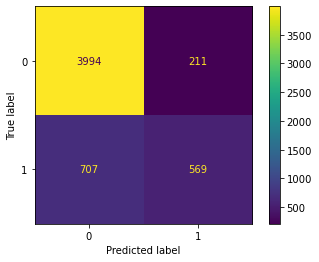

In [18]:
#random forest
rfc = RandomForestClassifier(max_depth = 15,random_state =42)

rfc.fit(X_train,y_train)

print(rfc.score(X_train,y_train))

print(rfc.score(X_test,y_test))

plot_confusion_matrix(rfc,X_test,y_test)

rfc_pred = rfc.predict(X_test)
print("accuracy:", accuracy_score(y_test,rfc_pred))

In [19]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

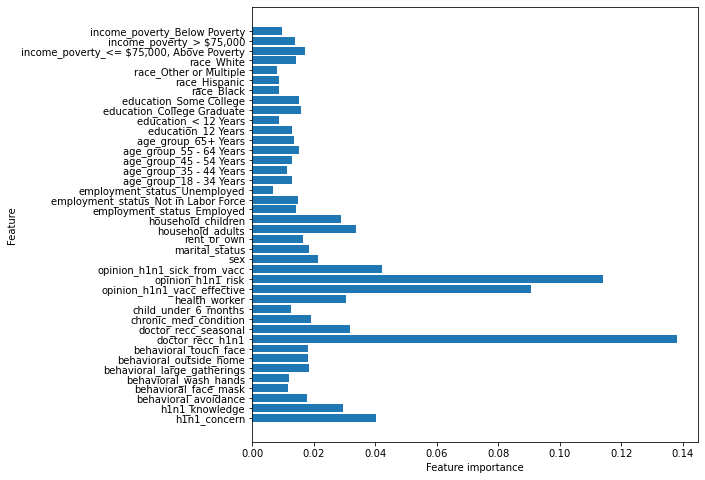

In [20]:
plot_feature_importances(rfc)

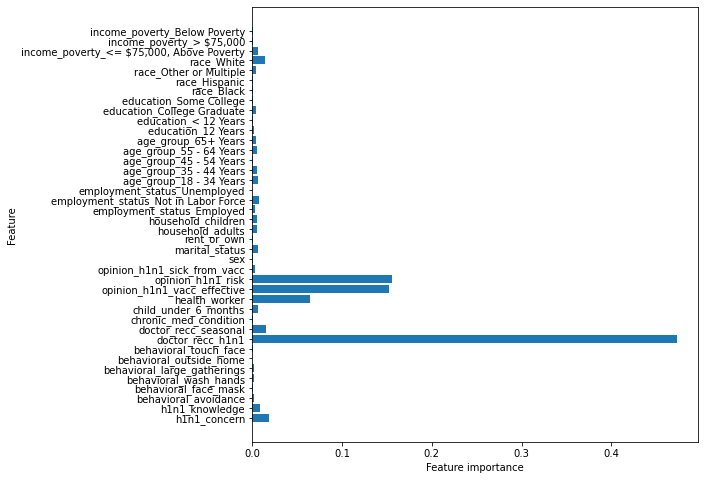

In [21]:
plot_feature_importances(tree_clf)

In [34]:
#basic logistic regression model

lr = LogisticRegression(max_iter = 1000,random_state=42)

lr.fit(X_train,y_train)

print("train score:", lr.score(X_train,y_train))

print("test score:", lr.score(X_test,y_test))

lr_pred = lr.predict(X_test)

lr_acc = accuracy_score(y_test,lr_pred)

print("lin reg accuracy:",lr_acc)

#find coefficients

coef = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(lr.coef_))],axis=1)
coef

train score: 0.8298260552244252
test score: 0.8332421091041781
lin reg accuracy: 0.8332421091041781
[[-0.08432611  0.13159442 -0.06901363  0.17256932  0.06555427 -0.15720066
  -0.08708108  0.02721728  1.95987772 -0.52520594  0.16508319  0.2616494
   0.87024389  0.66751162  0.47312154 -0.0277548  -0.19038178  0.1949511
   0.02781176 -0.01379421 -0.04729341  0.12283563  0.22524611  0.12837043
  -0.10287574 -0.19120443 -0.1446229   0.19153617  0.31935333 -0.26002707
  -0.52211634 -0.1250155  -0.23459498 -0.28256675  0.00980737  0.23629399
   0.1086518  -0.18659031 -0.07934241 -0.18576842]]
1


In [30]:
#knn model

knn = KNeighborsClassifier(n_neighbors = 10)

knn.fit(X_train,y_train)

print("train score: ",knn.score(X_train,y_train))
print("train score: ",knn.score(X_test,y_test))

knn_pred = knn.predict(X_test)

print("knn accuracy: ", accuracy_score(y_test,knn_pred))

#bad model

train score:  0.8315898309208125
train score:  0.80623973727422
knn accuracy:  0.80623973727422
